In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sdgym import load_dataset
from sdgym.evaluate import FeatureMaker
from benchmarks import binary_classification_benchmark
from data_utils import minority_data_undersample
from data_utils import ctgan_syntesize
from data_utils import label_column
from data_utils import t_sne
from collections import defaultdict
import seaborn as sns


## t-SNE plots

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 22561 samples in 0.296s...
[t-SNE] Computed neighbors for 22561 samples in 1.607s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22561
[t-SNE] Computed conditional probabilities for sample 2000 / 22561
[t-SNE] Computed conditional probabilities for sample 3000 / 22561
[t-SNE] Computed conditional probabilities for sample 4000 / 22561
[t-SNE] Computed conditional probabilities for sample 5000 / 22561
[t-SNE] Computed conditional probabilities for sample 6000 / 22561
[t-SNE] Computed conditional probabilities for sample 7000 / 22561
[t-SNE] Computed conditional probabilities for sample 8000 / 22561
[t-SNE] Computed conditional probabilities for sample 9000 / 22561
[t-SNE] Computed conditional probabilities for sample 10000 / 22561
[t-SNE] Computed conditional probabilities for sample 11000 / 22561
[t-SNE] Computed conditional probabilities for sample 12000 / 22561
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='tsne-one', ylabel='tsne-two'>

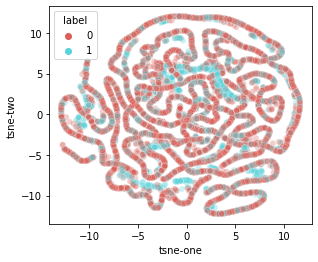

In [2]:
binary_data_sets = ['adult', 'census', 'credit']
categories_data_sets = ['covtype', 'intrusion', 'mnist12', 'mnist18']
train, test, meta, cat, ord = load_dataset('adult', benchmark=True)
label, index = label_column(train, meta)
train_feat = np.delete(train, index, axis=1)
results = t_sne(train_feat)
df = pd.DataFrame(results, columns=['tsne-one', 'tsne-two'])
df['label'] = label

plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax1
)

## Adult Classification on Original Data

In [3]:
train, test, meta, cat, ord = load_dataset('adult', benchmark=True)
fm = FeatureMaker(meta)
labels, index = label_column(train, meta)
print(f"Number of majority labels:{sum(labels==0)}")
print(f"Number of minority labels:{sum(labels==1)}")
f1_dict = defaultdict(list)

Number of majority labels:17088
Number of minority labels:5473


,DecisionTreeClassifier_f1,AdaBoostClassifier_f1,LogisticRegression_f1,MLPClassifier_f1
Original,0.756172,0.795618,0.756545,0.79119


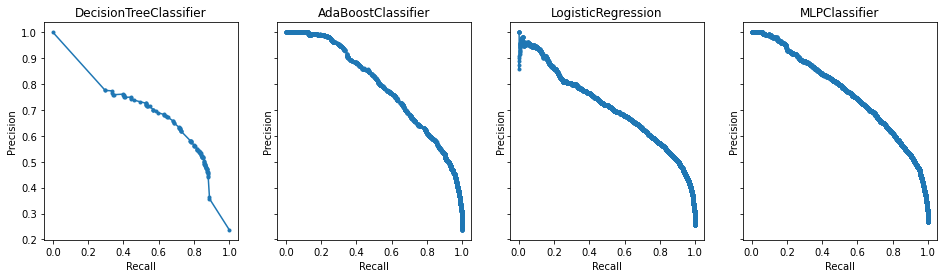

In [6]:
train_x, train_y = fm.make_features(train)
test_x, test_y = fm.make_features(test)
performance = binary_classification_benchmark(train_x, train_y, test_x, test_y)
figure, axes = plt.subplots(nrows=1, ncols=4, squeeze=False,
                            sharex=True, sharey=True, figsize=(16,4))
f1_dict.clear()
for i in range(len(performance)):
  name = performance[i]['name']
  f1_dict[f'{name}_f1'].append(performance[i]['macro_f1'])
  prec, recall= performance[i]['precision'], performance[i]['recall']
  axes[0,i].plot(recall, prec, marker='.', label="original_data")
  axes[0,i].set_xlabel("Recall")
  axes[0,i].set_ylabel("Precision")
  axes[0,i].set_title(performance[i]['name'])

df = pd.DataFrame(f1_dict, index=['Original'])
display(df)

## Minority undersample Classification

The number of undersampled minority:85


,DecisionTreeClassifier_f1,AdaBoostClassifier_f1,LogisticRegression_f1,MLPClassifier_f1
Original,0.756172,0.795618,0.756545,0.791190
UnderSample,0.707188,0.563380,0.755408,0.457081


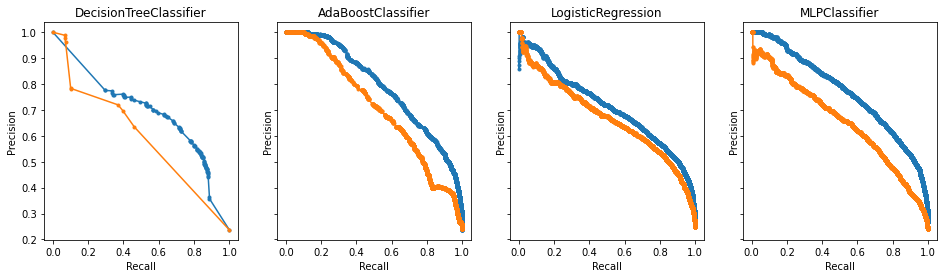

In [7]:
und_train = minority_data_undersample(train, meta, 0.005)
und_train_x, und_train_y = fm.make_features(und_train)
performance = binary_classification_benchmark(und_train_x, und_train_y, test_x, test_y)
for i in range(len(performance)):
  name = performance[i]['name']
  f1_dict[f'{name}_f1'].append(performance[i]['macro_f1'])
  prec, recall= performance[i]['precision'], performance[i]['recall']
  axes[0,i].plot(recall, prec, marker='.', label="under_sampled_data")

df = pd.DataFrame(f1_dict, index=['Original', 'UnderSample'])
display(df)
figure

## Syntesized Data Classification

,DecisionTreeClassifier_f1,AdaBoostClassifier_f1,LogisticRegression_f1,MLPClassifier_f1
Original,0.756172,0.795618,0.756545,0.791190
UnderSample,0.707188,0.563380,0.755408,0.457081
syntesized,0.608567,0.497388,0.640307,0.446008


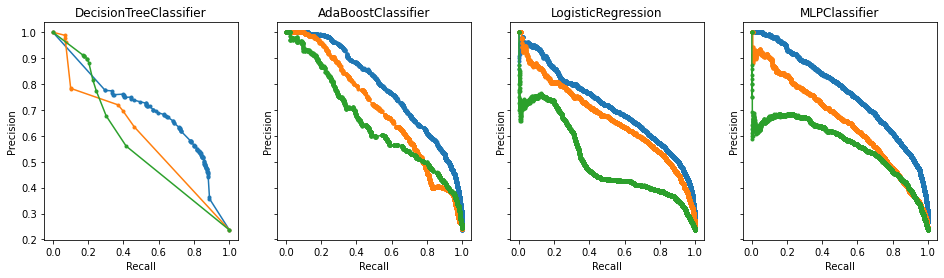

In [11]:
syntesized_data = ctgan_syntesize(und_train, cat, ord)
labels, index = label_column(syntesized_data, meta)
oversampled_minority = syntesized_data[labels==1]
syn_train = np.concatenate([und_train, oversampled_minority])
syn_train_x, syn_train_y = fm.make_features(syn_train)
performance = binary_classification_benchmark(syn_train_x, syn_train_y, test_x, test_y)
for i in range(len(performance)):
  name = performance[i]['name']
  f1_dict[f'{name}_f1'].append(performance[i]['macro_f1'])
  prec, recall= performance[i]['precision'], performance[i]['recall']
  axes[0,i].plot(recall, prec, marker='.', label="syntesized_data")

df = pd.DataFrame(f1_dict, index=['Original', 'UnderSample','syntesized'])
display(df)
figure